Epoch 1/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 53s 265ms/step - loss: 0.0257 - val_loss: 0.0068
Epoch 2/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 58s 298ms/step - loss: 0.0064 - val_loss: 0.0054
Epoch 3/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 74s 380ms/step - loss: 0.0053 - val_loss: 0.0048
Epoch 4/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 58s 297ms/step - loss: 0.0048 - val_loss: 0.0044
Epoch 5/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 56s 283ms/step - loss: 0.0045 - val_loss: 0.0041
Epoch 6/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 62s 316ms/step - loss: 0.0041 - val_loss: 0.0039
Epoch 7/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 65s 331ms/step - loss: 0.0039 - val_loss: 0.0040
Epoch 8/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 57s 292ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 9/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 57s 292ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 10/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 57s 289ms/step - loss: 0.0035 - val_loss: 0.0035
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


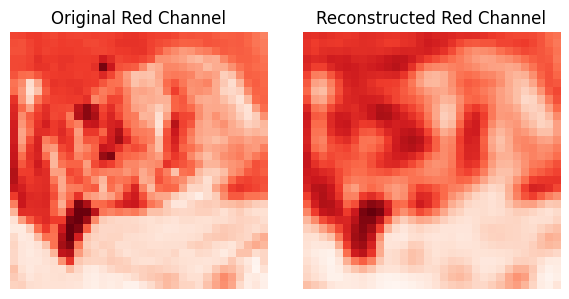

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
import numpy as np
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt

# Load CIFAR-10 dataset and normalize it
(x_train, _), (x_test, _) = cifar10.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Extract only the red channel for training and testing
x_train_red = x_train[:, :, :, 0:1]  # Single channel (red) for training
x_test_red = x_test[:, :, :, 0:1]  # Single channel (red) for testing

# Define the encoder
input_img = Input(shape=(32, 32, 1))  # Single-channel input
x = Conv2D(32, (3, 3), activation="relu", padding="same")(input_img)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
encoded = MaxPooling2D((2, 2), padding="same")(x)

# Define the decoder
x = Conv2D(32, (3, 3), activation="relu", padding="same")(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation="sigmoid", padding="same")(
    x
)  # Single-channel output

# Compile the autoencoder
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer="adam", loss="mean_squared_error")

# Train the autoencoder
autoencoder.fit(
    x_train_red,
    x_train_red,
    epochs=10,
    batch_size=256,
    shuffle=True,
    validation_data=(x_test_red, x_test_red),
)

# Visualize some outputs
# Select a sample test image
test_image = x_test_red[:1]

# Get reconstructed image
reconstructed_image = autoencoder.predict(test_image)

# Plot the original and reconstructed images
plt.figure(figsize=(6, 3))

# Original Red Channel Image
plt.subplot(1, 2, 1)
plt.imshow(test_image[0, :, :, 0], cmap="Reds")
plt.title("Original Red Channel")
plt.axis("off")

# Reconstructed Red Channel Images
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image[0, :, :, 0], cmap="Reds")
plt.title("Reconstructed Red Channel")
plt.axis("off")

plt.tight_layout()
plt.show()

In [6]:
autoencoder.save('./models/red_autoencoder.keras')

## Fine tune to include additional 2 dimensions

In [7]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.datasets import cifar10

# Load the single-channel (red) autoencoder model
autoencoder = load_model("./models/red_autoencoder.keras")

# Modify the input to accept 3 channels (RGB)
input_img = Input(shape=(32, 32, 3))  # RGB input with 3 channels

# Rebuild the encoder with 3-channel input
x = Conv2D(32, (3, 3), activation="relu", padding="same")(input_img)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
encoded = MaxPooling2D((2, 2), padding="same")(x)

# Rebuild the decoder with 3-channel output
x = Conv2D(32, (3, 3), activation="relu", padding="same")(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation="sigmoid", padding="same")(
    x
)  # RGB output with 3 channels

# Create the new RGB autoencoder model
rgb_autoencoder = Model(input_img, decoded)

# Compile the model
rgb_autoencoder.compile(optimizer="adam", loss="mean_squared_error")

# Load CIFAR-10 dataset and normalize it
(x_train, _), (x_test, _) = cifar10.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Fine-tune the model on full RGB data
rgb_autoencoder.fit(
    x_train,
    x_train,
    epochs=5,  # Fewer epochs for fine-tuning
    batch_size=256,
    shuffle=True,
    validation_data=(x_test, x_test),
)

# Save the updated RGB autoencoder model
rgb_autoencoder.save("./models/rgb_autoencoder.keras")

Epoch 1/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 68s 341ms/step - loss: 0.0276 - val_loss: 0.0085
Epoch 2/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 71s 361ms/step - loss: 0.0079 - val_loss: 0.0075
Epoch 3/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 68s 345ms/step - loss: 0.0066 - val_loss: 0.0060
Epoch 4/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 65s 332ms/step - loss: 0.0060 - val_loss: 0.0055
Epoch 5/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 65s 329ms/step - loss: 0.0056 - val_loss: 0.0052


## Same idea different method

Here I beleive I have figure out how to copy the weights from the 1st dimension of the kernel to initialize the 2 new dimensions of the kernel

In [84]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10

# Load CIFAR-10 and extract only the red channel
(x_train, _), (x_test, _) = cifar10.load_data()
x_train_red = x_train[..., 0:1] / 255.0  # Normalize and use only red channel
x_test_red = x_test[..., 0:1] / 255.0


# Autoencoder model for a single channel (red)
def build_single_channel_autoencoder():
    input_img = Input(shape=(32, 32, 1))
    x = Conv2D(32, (3, 3), activation="relu", padding="same")(input_img)
    x = MaxPooling2D((2, 2), padding="same")(x)
    x = Conv2D(16, (3, 3), activation="relu", padding="same")(x)
    encoded = MaxPooling2D((2, 2), padding="same")(x)

    x = Conv2D(16, (3, 3), activation="relu", padding="same")(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

    return Model(input_img, decoded)


# Build, compile, and train the single-channel autoencoder
autoencoder_red = build_single_channel_autoencoder()
autoencoder_red.compile(optimizer="adam", loss="mse")
autoencoder_red.fit(
    x_train_red,
    x_train_red,
    epochs=5,
    batch_size=128,
    validation_data=(x_test_red, x_test_red),
)

# Save weights from the single-channel model
single_channel_weights = autoencoder_red.get_weights()

Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 24s 56ms/step - loss: 0.0208 - val_loss: 0.0063
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 54ms/step - loss: 0.0058 - val_loss: 0.0051
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - loss: 0.0049 - val_loss: 0.0045
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 5/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 22s 55ms/step - loss: 0.0041 - val_loss: 0.0039


## Build new model with correct size, then copy weights from 3x3x1 kernels to 3x3x3 kernels (stacking 3 of the same 2d filters)

In [97]:
# Function to expand weights to 3 channels
import numpy as np
from tensorflow.keras.layers import Conv2D


def expand_weights_to_rgb(model, single_channel_weights):
    expanded_weights = []
    layer_idx = 0

    for i, layer in enumerate(model.layers):
        layer_weights = layer.get_weights()
        weights = single_channel_weights[layer_idx : layer_idx + len(layer_weights)]

        if isinstance(layer, Conv2D):
            old_shape = layer_weights[0].shape  # Shape of the kernel

            if i == len(model.layers) - 1 and old_shape[3] == 1:  # Output layer
                # Expand final layer weights along the output channel dimension
                w_expanded = np.concatenate([weights[0]] * 3, axis=3)
                expanded_weights.append(w_expanded)
                # Expand bias by duplicating it for each channel
                if len(layer_weights) > 1:
                    expanded_weights.append(np.repeat(weights[1], 3))
            elif old_shape[2] == 1:  # Intermediate layers with single channel input
                w_expanded = np.concatenate([weights[0]] * 3, axis=2)
                expanded_weights.append(w_expanded)
                if len(layer_weights) > 1:
                    expanded_weights.append(weights[1])  # Use bias as-is
            else:
                expanded_weights.append(weights[0])  # Use original RGB weights as-is
                if len(layer_weights) > 1:
                    expanded_weights.append(weights[1])  # Use bias as-is

            print(
                f"Layer '{layer.name}' old shape: {old_shape}, new shape: {w_expanded.shape}"
            )

        else:
            expanded_weights.extend(weights)  # Non-Conv2D layers keep original weights

        layer_idx += len(layer_weights)

        # Debug: confirm alignment with model's expected weights
        print(
            f"Layer '{layer.name}' expects {len(layer_weights)} weights, "
            f"expanded_weights now has {len(expanded_weights)} weights."
        )

    return expanded_weights


# Autoencoder model for 3 channels (RGB)
def build_rgb_autoencoder():
    input_img = Input(shape=(32, 32, 3))
    x = Conv2D(32, (3, 3), activation="relu", padding="same")(input_img)
    x = MaxPooling2D((2, 2), padding="same")(x)
    x = Conv2D(16, (3, 3), activation="relu", padding="same")(x)
    encoded = MaxPooling2D((2, 2), padding="same")(x)

    x = Conv2D(16, (3, 3), activation="relu", padding="same")(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

    return Model(input_img, decoded)


# Build the RGB autoencoder, set expanded weights, and continue training
autoencoder_rgb = build_rgb_autoencoder()
expanded_weights = expand_weights_to_rgb(autoencoder_red, single_channel_weights)
print(autoencoder_red.summary())
print(autoencoder_rgb.summary())
print(f"Single channel weights shape: {len(single_channel_weights)}")
print(f'Expanded weights shape: {len(expanded_weights)}')
autoencoder_rgb.set_weights(expanded_weights)

Layer 'input_layer_13' expects 0 weights, expanded_weights now has 0 weights.
Layer 'conv2d_57' old shape: (3, 3, 1, 32), new shape: (3, 3, 3, 32)
Layer 'conv2d_57' expects 2 weights, expanded_weights now has 2 weights.
Layer 'max_pooling2d_22' expects 0 weights, expanded_weights now has 2 weights.
Layer 'conv2d_58' old shape: (3, 3, 32, 16), new shape: (3, 3, 3, 32)
Layer 'conv2d_58' expects 2 weights, expanded_weights now has 4 weights.
Layer 'max_pooling2d_23' expects 0 weights, expanded_weights now has 4 weights.
Layer 'conv2d_59' old shape: (3, 3, 16, 16), new shape: (3, 3, 3, 32)
Layer 'conv2d_59' expects 2 weights, expanded_weights now has 6 weights.
Layer 'up_sampling2d_22' expects 0 weights, expanded_weights now has 6 weights.
Layer 'conv2d_60' old shape: (3, 3, 16, 32), new shape: (3, 3, 3, 32)
Layer 'conv2d_60' expects 2 weights, expanded_weights now has 8 weights.
Layer 'up_sampling2d_23' expects 0 weights, expanded_weights now has 8 weights.
Layer 'conv2d_61' old shape: (3

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 16, 16, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 8, 8, 16)       │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_22 (UpSampling2D) │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_60 (Conv2D)              │ (None, 16, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_23 (UpSampling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,581 (142.90 KB)

 Trainable params: 12,193 (47.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 24,388 (95.27 KB)

None


Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_26 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_122 (Conv2D)             │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_48 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_123 (Conv2D)             │ (None, 16, 16, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_124 (Conv2D)             │ (None, 8, 8, 16)       │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_48 (UpSampling2D) │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_125 (Conv2D)             │ (None, 16, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_49 (UpSampling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_126 (Conv2D)             │ (None, 32, 32, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,347 (52.14 KB)

 Trainable params: 13,347 (52.14 KB)

 Non-trainable params: 0 (0.00 B)

None
Single channel weights shape: 10
Expanded weights shape: 10


## Train without freezing weights

In [98]:
# Train the RGB autoencoder on all channels
x_train_rgb = x_train / 255.0  # Normalize full RGB input
x_test_rgb = x_test / 255.0
autoencoder_rgb.compile(optimizer="adam", loss="mse")
autoencoder_rgb.fit(
    x_train_rgb,
    x_train_rgb,
    epochs=10,
    batch_size=128,
    validation_data=(x_test_rgb, x_test_rgb),)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 29s 71ms/step - loss: 0.0206 - val_loss: 0.0068
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 27s 69ms/step - loss: 0.0065 - val_loss: 0.0058
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 26s 65ms/step - loss: 0.0056 - val_loss: 0.0050
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 27s 70ms/step - loss: 0.0050 - val_loss: 0.0047
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 25s 64ms/step - loss: 0.0047 - val_loss: 0.0045
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 27s 69ms/step - loss: 0.0045 - val_loss: 0.0043
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 31s 78ms/step - loss: 0.0043 - val_loss: 0.0042
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 38s 96ms/step - loss: 0.0043 - val_loss: 0.0042
Epoch 9/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 39s 100ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 10/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 36s 93ms/step - loss: 0.0041 - val_loss: 0.0040


In [57]:
layer1 = autoencoder_red.layers[1]
layer1.get_config()

{'name': 'conv2d_27',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'filters': 32,
 'kernel_size': (3, 3),
 'strides': (1, 1),
 'padding': 'same',
 'data_format': 'channels_last',
 'dilation_rate': (1, 1),
 'groups': 1,
 'activation': 'relu',
 'use_bias': True,
 'kernel_initializer': {'module': 'keras.initializers',
  'class_name': 'GlorotUniform',
  'config': {'seed': None},
  'registered_name': None},
 'bias_initializer': {'module': 'keras.initializers',
  'class_name': 'Zeros',
  'config': {},
  'registered_name': None},
 'kernel_regularizer': None,
 'bias_regularizer': None,
 'activity_regularizer': None,
 'kernel_constraint': None,
 'bias_constraint': None}

In [130]:
rgb_layer1 = autoencoder_rgb.layers[1]
kernel_weights = rgb_layer1.get_weights()[0]
red_channel_weights = kernel_weights[:, :, 0, :]
red_channel_weights_filter1 = red_channel_weights[:,:,0]
red_channel_weights_filter1

array([[ 0.02309387, -0.04982037, -0.10786336],
       [ 0.08113432,  0.0830029 , -0.00299077],
       [ 0.04369541, -0.09989434, -0.11073366]], dtype=float32)

In [132]:
rgb_layer1 = red_autoencoder.layers[1]
kernel_weights = rgb_layer1.get_weights()[0]
red_channel_weights = kernel_weights[:, :, 0, :]
red_channel_weights_filter1 = red_channel_weights[:, :, 0]
red_channel_weights_filter1

array([[ 0.06479185,  0.08549914,  0.04908791],
       [-0.09437862, -0.03767725,  0.08777307],
       [-0.04045472,  0.1371839 ,  0.07300409]], dtype=float32)

In [79]:
# Assume `layer` is your Conv2D layer
kernel_weights = rgb_layer1.get_weights()[0]  # Shape: (3, 3, input_channels, output_filters)

# Inspect the weights for each input channel individually
red_channel_weights = kernel_weights[:, :, 0, :]  # Red channel weights for all filters
green_channel_weights = kernel_weights[
    :, :, 1, :
]  # Green channel weights for all filters
blue_channel_weights = kernel_weights[
    :, :, 2, :
]  # Blue channel weights for all filters

print("Red Channel Weights:", red_channel_weights)

Red Channel Weights: [[[-5.56234382e-02  1.66511387e-02  1.51676267e-01 -7.19322637e-02
   -3.35244983e-02  1.01631181e-02  1.98534802e-02  7.21301138e-02
   -1.00014172e-01 -6.25250712e-02  1.04806505e-01 -3.42138391e-03
   -1.28484800e-01 -2.45775990e-02  2.61611603e-02 -1.20524436e-01
   -5.48204333e-02  1.54695779e-01  1.12747513e-02 -3.20095390e-01
   -2.54273526e-02  9.99626145e-02  6.36849999e-02  1.21373080e-01
    1.34844795e-01  3.05714868e-02  1.39815509e-01 -7.87925124e-02
   -1.25558227e-01 -9.49364454e-02  1.45346522e-01  1.91189170e-01]
  [-7.03079179e-02  5.79414442e-02  5.57755046e-02 -1.09412529e-01
   -4.45379354e-02 -4.45858985e-02 -6.45355508e-02 -5.56831546e-02
    6.28885776e-02  8.45640972e-02 -1.73263568e-02  6.23259973e-03
   -1.57682300e-01 -3.96484946e-04 -1.23042546e-01  1.61530480e-01
    9.20645371e-02  1.55841216e-01  1.21652111e-01 -3.68152678e-01
   -1.29897013e-01  1.26354814e-01 -1.14716098e-01  2.94689033e-02
    6.71179220e-03 -1.22618504e-01  2.10

## Thinking about how we can more dynamically adjust a model based on new dimensions

What about creating the new model and comparing the differences between them?


In [99]:
from tensorflow.keras.models import Model


def compare_model_shapes(model1: Model, model2: Model):
    # Ensure the models have the same number of layers
    if len(model1.layers) != len(model2.layers):
        print("Models have a different number of layers.")
        print(
            f"Model 1 has {len(model1.layers)} layers, Model 2 has {len(model2.layers)} layers."
        )
        return

    # Iterate through layers and compare shapes
    for i, (layer1, layer2) in enumerate(zip(model1.layers, model2.layers)):
        shape1 = layer1.output_shape
        shape2 = layer2.output_shape

        if shape1 != shape2:
            print(f"Layer {i} - {layer1.name} vs {layer2.name}")
            print(f"  Model 1 shape: {shape1}")
            print(f"  Model 2 shape: {shape2}")


# Example usage:
compare_model_shapes(autoencoder_rgb, autoencoder_red)

AttributeError: 'InputLayer' object has no attribute 'output_shape'